# Elevated-plus maze analysis

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.ndimage import filters
import os
import time
import custom
from utilities import *
import pdb

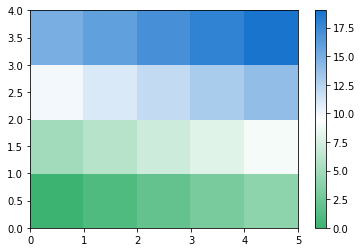

In [2]:
cmap = custom.diverging_cmap(np.array([60, 179, 113])/255., np.array([24, 116, 205])/255.)
plt.pcolor(np.arange(20).reshape(4, 5), cmap=cmap)
plt.colorbar()

In [3]:
# Output paramters

output_dir = './data/epm'
opts_fig = {
    'dpi': 300,
    'frameon': False,
    'bbox_inches': 'tight',
    'transparent': True
}

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

## Import and setup data

In [4]:
# Parameters
filename = './data/epm.h5'
data_type = 'trace'  # 'trace' or 'event'

In [10]:
# Import data
with pd.HDFStore(filename, mode='r') as hf:
    neural_activity = hf['neural'][data_type]
    behav = hf['behav']

# Remove bad data
neural_activity = neural_activity.drop('H169', axis=1)
behav = behav.drop('H169', axis=1)

Normalize neural data by dividing standard deviation within each neuron.

In [11]:
# Normalize imaging data

# neural_norm = (neural_activity - neural_activity.mean()) * (1 / neural_activity.std())     # Kernel kept dying if simply divide by `base_std`
neural_norm = neural_activity * (1 / neural_activity.std())

# # Remove cells with no activity/std in baseline
neural_norm = neural_norm.replace([np.inf, -np.inf], np.nan)
neural_norm = neural_norm.dropna(axis=1, how='all')

n_cells = neural_norm.shape[1]

In [12]:
# Normalize features

col_no_norm = [
    'In zone(Center / center-point)',
    'In zone(Closed arms / center-point)',
    'In zone(Open arms / center-point)',
    'Mobility state(Immobile)',
    'Mobility state(Mobile)',
    'Mobility state(Highly mobile)',
    'Zone transition(center-point / Center > Closed arms)',
    'Zone transition(center-point / Center > Open arms)',
    'Zone transition(center-point / Closed arms > Center)',
    'Zone transition(center-point / Open arms > Center)',
]

behav_norm = behav.copy()
for column in behav.columns:
    if column[1] not in col_no_norm:
#         behav_norm[column] = (behav[column] - behav[column].mean()) * (1 /  (behav[column].abs().max() or 1))  # if max is 0, entire column is 0
        behav_norm[column] = (behav[column] - behav[column].mean()) * (1 /  (behav[column].std() or 1))  # if max is 0, entire column is 0
# behav_norm = (hf['behav'] - hf['behav'].mean()) * (1 /  hf['behav'].std())

# Overview

## Sample

In [43]:
neural_arm.loc[(subj), :].loc[(slice(None), -1), :].index.get_level_values('neuron')

Int64Index([3, 4, 5, 7, 9, 13, 14, 15, 16, 30, 32, 36, 39, 43, 44, 45, 50], dtype='int64', name=u'neuron')

Saved ./data/epm\sample.png
Saved ./data/epm\sample.svg


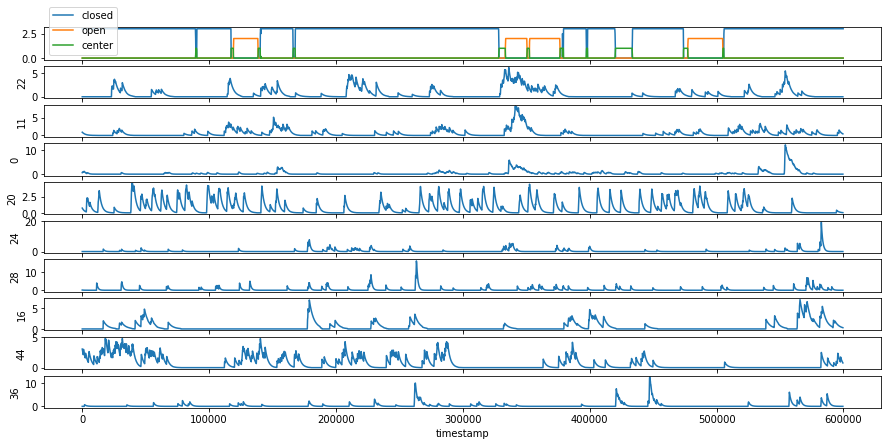

In [13]:
plt_name = 'sample'

subj = 'H186'
neurons = [
    22, 11, 0,
    20, 24, 28,
    16, 44, 36,
]
# neurons = [30, 32, 36, 39, 43, 44, 45, 50]

fig, axes = plt.subplots(nrows=10, sharex=True, figsize=(15, 7))

(behav.loc[:, (subj, 'In zone(Closed arms / center-point)')] * 3).plot(ax=axes[0], label='closed')
(behav.loc[:, (subj, 'In zone(Open arms / center-point)')] * 2).plot(ax=axes[0], label='open')
(behav.loc[:, (subj, 'In zone(Center / center-point)')] * 1).plot(ax=axes[0], label='center')
axes[0].legend()

for ax, neur in zip(axes[1:], neurons):
    neural_norm.loc[:, (subj, neur)].plot(ax=ax)
    ax.set_ylabel(neur)

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

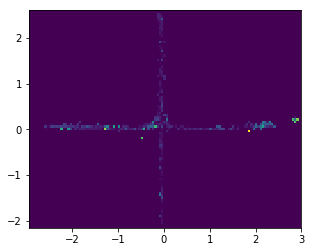

In [14]:
# Get example data for neural map
# PNOC188, 1 is good for open
# PNOC188, 15 is good for closed

subj = 'H188'
cell = 15

ex_data = pd.concat(
    [
        neural_norm[subj, cell],
        behav_norm.loc[slice(None), (subj, ['X center', 'Y center'])],
    ],
    axis=1
).dropna(axis=0)
ex_data.columns = ex_data.columns.droplevel(level=0)

hm, X, Y = custom.activity_map(ex_data['X center'], ex_data['Y center'], ex_data[cell], binsize=0.05)
# hm, X, Y = custom.activity_map(ex_data['X center'], np.zeros(ex_data.shape[0]) + np.random.normal(scale=.1, size=ex_data.shape[0]), ex_data[cell], binsize=0.05)
plt.pcolormesh(X, Y, hm.T)
plt.axis('image');

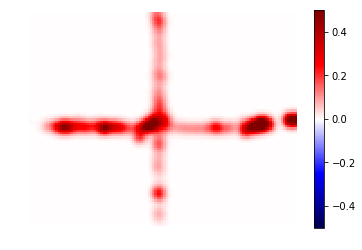

In [15]:
# Plot example neural map

plt_name = 'epm-neural-map-{}-{}'.format(subj, cell)

C = filters.gaussian_filter(hm, 2, truncate=5)

fig, ax = plt.subplots()

import matplotlib.cm
my_cmap = matplotlib.cm.get_cmap('seismic')
my_cmap.set_under('w', alpha=0)

im = ax.pcolormesh(X, Y, C.T, cmap=my_cmap, vmin=-0.5, vmax=0.5)
ax.axis('image')
ax.axis('off')
fig.colorbar(im)

# savefig(os.path.join(output_dir, plt_name + '.png'), fig)
# savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

## Behavior

Saved ./data/epm\arm-time.png
Saved ./data/epm\arm-time.svg


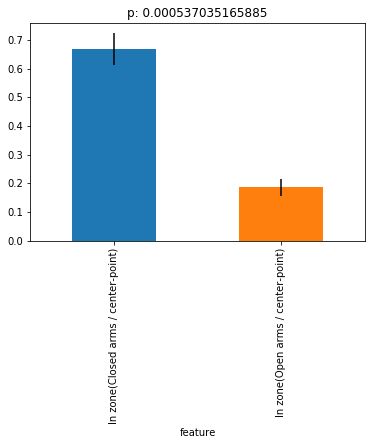

In [16]:
plt_name = 'arm-time'

data = behav.mean()
Y = data.mean(level='feature')[['In zone(Closed arms / center-point)', 'In zone(Open arms / center-point)']]
E = data.sem(level='feature')[['In zone(Closed arms / center-point)', 'In zone(Open arms / center-point)']]

Y.plot.bar(yerr=E);

closed_arm_time = behav_norm.xs('In zone(Closed arms / center-point)', axis=1, level='feature').mean()
open_arm_time = behav_norm.xs('In zone(Open arms / center-point)', axis=1, level='feature').mean()
t, p = scipy.stats.ttest_1samp(open_arm_time / (closed_arm_time + open_arm_time), 0.5)
plt.title('p: {}'.format(p))

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

## Neural

In [17]:
n_bins = 10
max_d = 35
bins = np.arange(n_bins + 1, dtype=float) / n_bins * max_d
binned_loc = pd.cut(behav.xs('Distance to zone', axis=1, level='feature').stack('subject'), bins).unstack('subject')
binned_loc.columns = pd.MultiIndex.from_product([binned_loc.columns, ['Distance to zone']], names=['subject', 'feature'])

df_zone = behav.loc[:, (slice(None), ['In zone(Center / center-point)', 'In zone(Closed arms / center-point)', 'In zone(Open arms / center-point)'])].astype(bool).sort_index(axis=1)
for subj, df in df_zone.groupby(axis=1, level='subject'):
    df_zone[(subj, 'zone')] = pd.Series(['center' if x else 'closed' if y else 'open' if z else 'na' for (x, y, z), in zip(df.as_matrix())], index=df.index)

df_loc = pd.concat([binned_loc, df_zone], axis=1).sort_index(axis=1)

In [18]:
loc = df_loc.loc[:, (slice(None), ['zone', 'Distance to zone'])]
dfs = {}
for subj, df in df_loc.groupby(axis=1, level='subject'):
    dfs[subj] = pd.concat([loc[subj], neural_norm[subj]], axis=1).groupby(['Distance to zone', 'zone']).mean()

neural_zone = pd.concat(dfs, axis=1)

Saved ./data/epm\neural-by-arm-distance.png


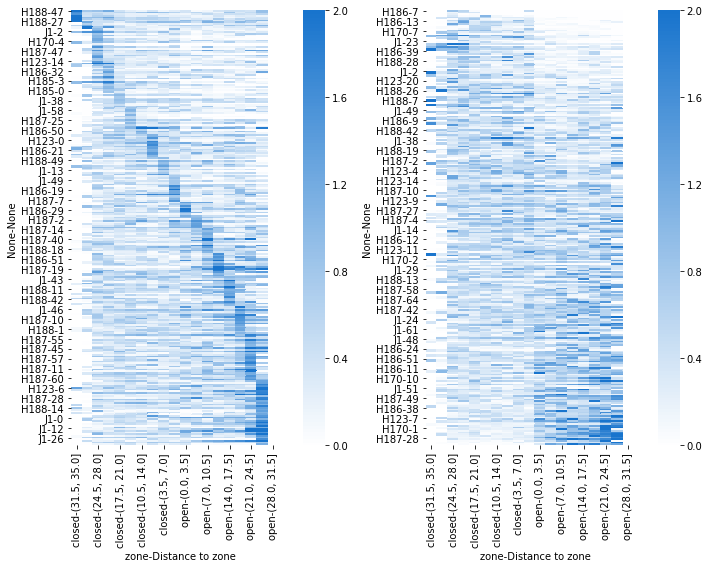

Saved ./data/epm\neural-by-arm-distance.svg


In [19]:
plt_name = 'neural-by-arm-distance'

neural_zone_clean = neural_zone.loc[(slice(None), ['open', 'closed']), :].reorder_levels(['zone', 'Distance to zone']).sort_index()
neural_zone_clean = neural_zone_clean.iloc[range(10)[::-1] + range(10, 20), :]

sort_ix_peak = np.nanargmax(neural_zone_clean.as_matrix(), axis=0).argsort()
sort_ix = neural_zone_clean.mean(axis=0, level='zone')
sort_ix = sort_ix.loc['open'] / sort_ix.loc['closed']
sort_ix_mean = sort_ix.as_matrix().argsort()

fig, axes = plt.subplots(ncols=2, figsize=(10, 8))
sns.heatmap(neural_zone_clean.iloc[:, sort_ix_peak].T, ax=axes[0], center=0, vmax=2, cmap=cmap);
sns.heatmap(neural_zone_clean.iloc[:, sort_ix_mean].T, ax=axes[1], center=0, vmax=2, cmap=cmap);
fig.tight_layout()

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    plt.show()
    for ax in axes:
        ax.collections[0].remove()
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

Saved ./data/final/epm/neural-by-arm-distance.png


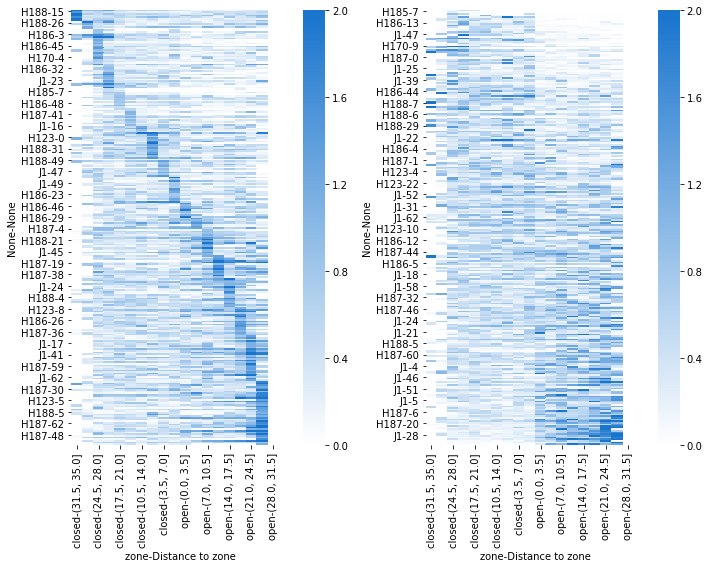

Saved ./data/final/epm/neural-by-arm-distance.svg


In [14]:
# OLD

# Group neurons

In [20]:
alpha = 0.05
p_thresh = 0.05 / n_cells

In [21]:
# Average activity by location

center_col = 'In zone(Center / center-point)'
closed_col = 'In zone(Closed arms / center-point)'
open_col = 'In zone(Open arms / center-point)'

n_cells = neural_norm.shape[1]

# Average activity for each neuron in each zone
neural_arm = pd.DataFrame(
    index=neural_norm.columns,
    columns=['center', 'open', 'closed'],
    dtype=float
)
neural_response = pd.DataFrame(index=['group', 'difference', 'p'], columns=neural_norm.columns)

for subj, df in neural_norm.groupby(axis=1, level='subject'):
    center_ix = behav_norm[(subj, center_col)] == 1
    closed_ix = behav_norm[(subj, closed_col)] == 1
    open_ix = behav_norm[(subj, open_col)] == 1
    
    neural_arm.loc[subj, 'center'] = df.loc[center_ix, :].mean(axis=0)
    neural_arm.loc[subj, 'closed'] = df.loc[closed_ix, :].mean(axis=0)
    neural_arm.loc[subj, 'open'] = df.loc[open_ix, :].mean(axis=0)
    
    for cell in df.loc[:, subj]:
        X1 = df.loc[closed_ix, (slice(None), cell)]
        X2 = df.loc[open_ix, (slice(None), cell)]
        _, neural_response.loc['p', (subj, cell)] = scipy.stats.mannwhitneyu(X1, X2)

# Calculate difference between arms
neural_response.loc['difference'] = (neural_arm['open'] - neural_arm['closed'])
significant_ix = neural_response.loc['p'] < p_thresh

# Define groups
neural_response.loc['group'] = 0
exc_ix = neural_response.loc['difference'] > 0
inh_ix = neural_response.loc['difference'] < 0
neural_response.loc['group', neural_response.columns[significant_ix & exc_ix]] = 1
neural_response.loc['group', neural_response.columns[significant_ix & inh_ix]] = -1

# Add groups to `neural_arm`
neural_arm.index = pd.MultiIndex.from_tuples(
    [x + (neural_response.loc['group', x], ) for x in neural_arm.index],
    names = ['subject', 'neuron', 'response']
)

Saved ./data/epm\neural-grouping.png
Saved ./data/epm\neural-grouping.svg


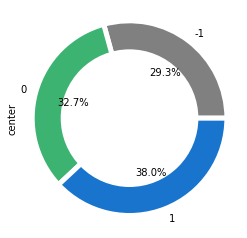

In [22]:
plt_name = 'neural-grouping'

counts = neural_arm.groupby('response').count()['center']

fig, ax = plt.subplots()
counts.plot.pie(ax=ax, colors=['gray', np.array([60, 179, 113])/255., np.array([24, 116, 205])/255.], autopct='%1.1f%%', wedgeprops={'lw': 5, 'ec': 'w'})
ax.axis('image')
centre_circle = plt.Circle((0, 0), 1 / 1.4142, color='none', fc='white')
ax.add_artist(centre_circle);

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

Saved ./data/final/epm/neural-grouping.png
Saved ./data/final/epm/neural-grouping.svg


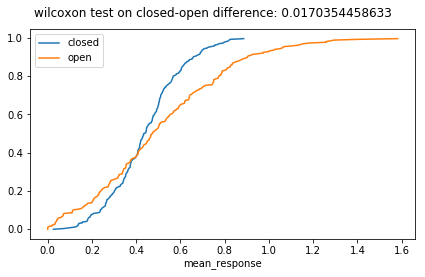

In [18]:
fig, ax = plt.subplots()

custom.cdf(neural_arm['closed'].as_matrix(), ax=ax, label='closed')
custom.cdf(neural_arm['open'].as_matrix(), ax=ax, label='open')
ax.legend()
ax.set_xlabel('mean_response')

W, p_val = scipy.stats.wilcoxon(neural_arm['open'], neural_arm['closed'])
fig.suptitle('wilcoxon test on closed-open difference: {}'.format(p_val))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)
    neural_arm.to_csv(os.path.join(output_dir, plt_name + '.csv'))

## Group data

Saved ./data/epm\epm-response-arm-grouped.png
Saved ./data/epm\epm-response-arm-grouped.svg


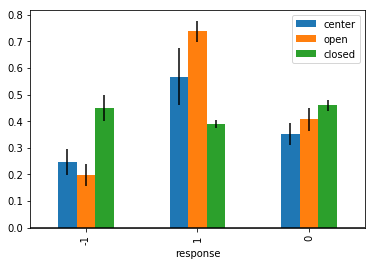

In [33]:
plt_name = 'epm-response-arm-grouped'

fig, ax = plt.subplots()

animal_avg = neural_arm.mean(level=['subject', 'response'])
Y = animal_avg.mean(level='response')
E = animal_avg.sem(level='response')
Y.plot.bar(ax=ax, yerr=E);
ax.axhline(y=0, color='k')

if plt_name:
    savefig(os.path.join(output_dir, plt_name) + '.png', fig)
    savefig(os.path.join(output_dir, plt_name) + '.svg', fig)
    animal_avg.to_csv(os.path.join(output_dir, plt_name) + '.csv')

In [ ]:
subj = 'PNOC123'
cell = 4
ex_data = pd.concat(
    [
        behav_norm.loc[slice(None), (subj, ['X center', 'Y center'])],
        neural_norm.loc[slice(None), (subj, cell)]
    ],
    axis=1
).dropna(axis=0)

hm, X, Y = custom.activity_map(
    ex_data[(subj, 'X center')], ex_data[(subj, 'Y center')], ex_data[(subj, cell)],
    binsize=0.02, buffer=0.2
)

# Match neurons from homecage

In [39]:
%store neural_arm

Stored 'neural_arm' (DataFrame)
